# Correlation between boundary and other modalities

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from ALLCools.mcds import MCDS
from ALLCools.mcds.utilities import calculate_posterior_mc_frac

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'msn': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['msn'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']


In [4]:
group_name = 'neu'

In [5]:
leg = pd.Index(leg[group_name])
legname = leg.map(leg2name)
res = 25000

In [6]:
indir = '/data/hba/domain_majortype/'
outdir = f'/home/jzhou_salk_edu/sky_workdir/hba/domain_majortype/diff/{group_name}/'


In [7]:
binall = pd.read_hdf(f'{outdir}bin_stats.hdf', key='data')


In [8]:
mcds = MCDS.open('/data/hba/mc_majortype/MajorType.mcds', var_dim='chrom5k')
mcds['chrom10k_even'] = mcds['chrom5k_chrom'].to_pandas().astype(str) + '_' + (mcds['chrom5k_start'] // 10000 * 2).to_pandas().astype(str)
mcds['chrom10k_odd'] = mcds['chrom5k_chrom'].to_pandas().astype(str) + '_' + ((mcds['chrom5k_start'] + 5000) // 10000 * 2 - 1).to_pandas().astype(str)
mcds


<xarray.MCDS>
Dimensions:        (cell: 40, chrom5k: 617669, count_type: 2, mc_type: 2)
Coordinates:
  * cell           (cell) <U10 'Amy' 'ASC' 'CA1' 'CA2' ... 'THM_MB' 'Vip' 'VLMC'
  * chrom5k        (chrom5k) object 'chr1_0' 'chr1_1' ... 'chrY_11445'
    chrom5k_chrom  (chrom5k) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chrom5k_end    (chrom5k) int64 5000 10000 15000 ... 57225000 57227415
    chrom5k_start  (chrom5k) int64 0 5000 10000 ... 57215000 57220000 57225000
  * count_type     (count_type) <U3 'mc' 'cov'
  * mc_type        (mc_type) <U3 'CGN' 'CHN'
Data variables:
    chrom5k_da     (cell, chrom5k, mc_type, count_type) uint32 dask.array<chunksize=(5, 77209, 1, 1), meta=np.ndarray>
    chrom10k_even  (chrom5k) object 'chr1_0' 'chr1_0' ... 'chrY_11444'
    chrom10k_odd   (chrom5k) object 'chr1_-1' 'chr1_1' ... 'chrY_11445'
Attributes:
    obs_dim:  cell
    var_dim:  chrom5k

### mCG

In [9]:
boundcg = pd.DataFrame(index=binall.index, columns=leg)


In [10]:
mc = mcds['chrom5k_da'].sel(count_type='mc', mc_type='CGN').to_pandas().T
mc['chrom10k'] = mcds['chrom10k_odd'].to_pandas()
mc = mc.groupby('chrom10k').sum().T
cov = mcds['chrom5k_da'].sel(count_type='cov', mc_type='CGN').to_pandas().T
cov['chrom10k'] = mcds['chrom10k_odd'].to_pandas()
cov = cov.groupby('chrom10k').sum().T


In [11]:
binfilter = ['_'.join(xx.split('_')[:-1]) for xx in mc.columns]
binfilter = [(len(xx)<6) and (xx not in ['chrM','chrX','chrY']) for xx in binfilter]
print(np.sum(binfilter))
mc = mc.loc[leg, binfilter]
cov = cov.loc[leg, binfilter]
print(mc.shape, cov.shape)


287523
(21, 287523) (21, 287523)


In [12]:
ratio = calculate_posterior_mc_frac(mc.values, cov.values)
ratio = pd.DataFrame(ratio, index=leg, columns=mc.columns)
ratio


chrom10k,chr10_-1,chr10_1,chr10_10001,chr10_10003,chr10_10005,chr10_10007,chr10_10009,chr10_1001,chr10_10011,chr10_10013,...,chr9_9983,chr9_9985,chr9_9987,chr9_9989,chr9_999,chr9_9991,chr9_9993,chr9_9995,chr9_9997,chr9_9999
L23_IT,1.0,0.860457,1.081336,0.925333,1.009707,1.112735,1.108767,1.073129,0.951386,0.582522,...,1.0,1.0,1.0,1.0,1.103275,1.0,1.0,1.0,1.0,1.0
L4_IT,1.0,0.823696,1.075727,0.914209,0.981365,1.105991,1.093843,1.056361,0.940196,0.554439,...,1.0,1.0,1.0,1.0,1.074466,1.0,1.0,1.0,1.0,1.0
L5_IT,1.0,0.866910,1.095000,0.987629,1.034343,1.093693,1.091953,1.070210,1.022007,0.581350,...,1.0,1.0,1.0,1.0,1.068948,1.0,1.0,1.0,1.0,1.0
L6_IT,1.0,0.832396,1.101325,0.912712,1.015612,1.102152,1.099118,1.065947,0.907962,0.593821,...,1.0,1.0,1.0,1.0,1.079558,1.0,1.0,1.0,1.0,1.0
L6_IT_Car3,1.0,0.870886,1.103143,0.981731,1.015656,1.099449,1.027843,1.066831,0.961772,0.537093,...,1.0,1.0,1.0,1.0,1.054659,1.0,1.0,1.0,1.0,1.0
L56_NP,1.0,0.789294,1.065180,1.019229,1.034690,1.069006,1.045871,1.053416,1.031039,0.558070,...,1.0,1.0,1.0,1.0,1.073882,1.0,1.0,1.0,1.0,1.0
L6_CT,1.0,0.850089,1.095890,0.944332,1.006207,1.098835,1.085214,1.042651,1.021171,0.540605,...,1.0,1.0,1.0,1.0,1.096978,1.0,1.0,1.0,1.0,1.0
L6b,1.0,0.874737,1.082416,0.972364,1.032669,1.104728,1.072531,1.067300,1.029268,0.539889,...,1.0,1.0,1.0,1.0,1.102754,1.0,1.0,1.0,1.0,1.0
Amy,1.0,0.849339,1.121909,0.955589,1.021628,1.111045,1.108338,1.034604,0.975217,0.498814,...,1.0,1.0,1.0,1.0,1.098151,1.0,1.0,1.0,1.0,1.0
Lamp5,1.0,0.803441,1.099491,0.901131,0.996747,1.084012,1.084341,1.061091,1.065331,0.573551,...,1.0,1.0,1.0,1.0,1.029678,1.0,1.0,1.0,1.0,1.0


In [13]:
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000!=0)#  & idx1.isin(ratio.columns)
boundcg.loc[selb] = (ratio.loc[:, idx1[selb]].values + ratio.loc[:, idx2[selb]].values).T / 2


In [14]:
mc = mcds['chrom5k_da'].sel(count_type='mc', mc_type='CGN').to_pandas().T
mc['chrom10k'] = mcds['chrom10k_even'].to_pandas()
mc = mc.groupby('chrom10k').sum().T
cov = mcds['chrom5k_da'].sel(count_type='cov', mc_type='CGN').to_pandas().T
cov['chrom10k'] = mcds['chrom10k_even'].to_pandas()
cov = cov.groupby('chrom10k').sum().T


In [15]:
binfilter = ['_'.join(xx.split('_')[:-1]) for xx in mc.columns]
binfilter = [(len(xx)<6) and (xx not in ['chrM','chrX','chrY']) for xx in binfilter]
print(np.sum(binfilter))
mc = mc.loc[leg, binfilter]
cov = cov.loc[leg, binfilter]
print(mc.shape, cov.shape)


287509
(21, 287509) (21, 287509)


In [16]:
ratio = calculate_posterior_mc_frac(mc.values, cov.values)
ratio = pd.DataFrame(ratio, index=leg, columns=mc.columns)
ratio


chrom10k,chr10_0,chr10_10,chr10_100,chr10_1000,chr10_10000,chr10_10002,chr10_10004,chr10_10006,chr10_10008,chr10_10010,...,chr9_9980,chr9_9982,chr9_9984,chr9_9986,chr9_9988,chr9_9990,chr9_9992,chr9_9994,chr9_9996,chr9_9998
L23_IT,1.0,1.030605,0.938468,1.079237,1.087932,1.036463,0.933259,1.085677,1.113516,1.092081,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L4_IT,1.0,1.008030,0.893732,1.061923,1.084499,1.066191,0.883820,1.083390,1.100948,1.046365,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L5_IT,1.0,1.035229,0.968205,1.064959,1.097828,1.078424,0.974695,1.077973,1.091472,1.080833,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_IT,1.0,1.043728,1.006064,1.036545,1.108225,1.035341,0.927944,1.081138,1.100847,1.058464,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_IT_Car3,1.0,1.031033,1.024065,0.972414,1.106033,1.069932,0.960716,1.080387,1.014772,1.059353,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L56_NP,1.0,1.024043,1.067959,1.031688,1.077790,1.064895,1.004588,1.056444,1.054735,1.060728,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_CT,1.0,1.025605,1.000952,1.033709,1.105316,1.079336,0.916573,1.080173,1.081485,1.098547,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6b,1.0,1.051203,1.039012,1.055885,1.094319,1.048304,0.974152,1.092275,1.058137,1.089253,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Amy,1.0,1.037157,0.883397,0.945863,1.126014,1.067755,0.954871,1.078414,1.115085,1.086908,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Lamp5,1.0,0.945802,1.048737,1.020667,1.102167,0.995533,0.926336,1.069959,1.081162,1.089796,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000==0) & idx1.isin(ratio.columns)
boundcg.loc[selb] = (ratio.loc[:, idx1[selb]].values + ratio.loc[:, idx2[selb]].values).T / 2


### mCH

In [18]:
boundch = pd.DataFrame(index=binall.index, columns=leg)


In [19]:
mc = mcds['chrom5k_da'].sel(count_type='mc', mc_type='CHN').to_pandas().T
mc['chrom10k'] = mcds['chrom10k_odd'].to_pandas()
mc = mc.groupby('chrom10k').sum().T
cov = mcds['chrom5k_da'].sel(count_type='cov', mc_type='CHN').to_pandas().T
cov['chrom10k'] = mcds['chrom10k_odd'].to_pandas()
cov = cov.groupby('chrom10k').sum().T


In [20]:
binfilter = ['_'.join(xx.split('_')[:-1]) for xx in mc.columns]
binfilter = [(len(xx)<6) and (xx not in ['chrM','chrX','chrY']) for xx in binfilter]
print(np.sum(binfilter))
mc = mc.loc[leg, binfilter]
cov = cov.loc[leg, binfilter]
print(mc.shape, cov.shape)


287523
(21, 287523) (21, 287523)


In [21]:
ratio = calculate_posterior_mc_frac(mc.values, cov.values)
ratio = pd.DataFrame(ratio, index=leg, columns=mc.columns)
ratio


chrom10k,chr10_-1,chr10_1,chr10_10001,chr10_10003,chr10_10005,chr10_10007,chr10_10009,chr10_1001,chr10_10011,chr10_10013,...,chr9_9983,chr9_9985,chr9_9987,chr9_9989,chr9_999,chr9_9991,chr9_9993,chr9_9995,chr9_9997,chr9_9999
L23_IT,1.0,0.510464,0.441238,0.856999,1.229206,1.541424,1.589255,1.146245,1.419087,0.385546,...,1.0,1.0,1.0,1.0,0.911612,1.0,1.0,1.0,1.0,1.0
L4_IT,1.0,0.424107,0.397881,0.681891,0.994451,1.350999,1.335008,1.133499,1.108866,0.333833,...,1.0,1.0,1.0,1.0,0.764278,1.0,1.0,1.0,1.0,1.0
L5_IT,1.0,0.382084,0.450242,0.937998,1.271952,1.531300,1.513247,1.199643,1.342807,0.344674,...,1.0,1.0,1.0,1.0,0.742818,1.0,1.0,1.0,1.0,1.0
L6_IT,1.0,0.516017,0.407969,0.842039,1.121085,1.496506,1.548475,1.164626,1.119029,0.315417,...,1.0,1.0,1.0,1.0,0.696133,1.0,1.0,1.0,1.0,1.0
L6_IT_Car3,1.0,0.501950,0.430480,0.856359,1.082338,1.393629,1.143643,1.204057,1.161465,0.339972,...,1.0,1.0,1.0,1.0,0.426450,1.0,1.0,1.0,1.0,1.0
L56_NP,1.0,0.320368,0.407804,0.852860,1.271590,1.428042,1.314577,1.145670,1.175423,0.216557,...,1.0,1.0,1.0,1.0,0.719350,1.0,1.0,1.0,1.0,1.0
L6_CT,1.0,0.377183,0.380987,0.793518,1.104818,1.291011,1.302317,1.083256,1.146751,0.319666,...,1.0,1.0,1.0,1.0,0.708590,1.0,1.0,1.0,1.0,1.0
L6b,1.0,0.395342,0.428573,0.888223,1.155397,1.554271,1.391349,1.151900,1.298691,0.288390,...,1.0,1.0,1.0,1.0,0.760155,1.0,1.0,1.0,1.0,1.0
Amy,1.0,0.395040,0.504294,0.836117,1.225487,1.352221,1.581872,0.951827,1.300263,0.360894,...,1.0,1.0,1.0,1.0,0.557824,1.0,1.0,1.0,1.0,1.0
Lamp5,1.0,0.344861,1.379219,1.571598,1.727956,1.958670,2.215138,1.033501,1.897049,0.497977,...,1.0,1.0,1.0,1.0,0.426988,1.0,1.0,1.0,1.0,1.0


In [22]:
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000!=0)# & idx1.isin(ratio.columns)
boundch.loc[selb] = (ratio.loc[:, idx1[selb]].values + ratio.loc[:, idx2[selb]].values).T / 2


In [23]:
mc = mcds['chrom5k_da'].sel(count_type='mc', mc_type='CHN').to_pandas().T
mc['chrom10k'] = mcds['chrom10k_even'].to_pandas()
mc = mc.groupby('chrom10k').sum().T
cov = mcds['chrom5k_da'].sel(count_type='cov', mc_type='CHN').to_pandas().T
cov['chrom10k'] = mcds['chrom10k_even'].to_pandas()
cov = cov.groupby('chrom10k').sum().T


In [24]:
binfilter = ['_'.join(xx.split('_')[:-1]) for xx in mc.columns]
binfilter = [(len(xx)<6) and (xx not in ['chrM','chrX','chrY']) for xx in binfilter]
print(np.sum(binfilter))
mc = mc.loc[leg, binfilter]
cov = cov.loc[leg, binfilter]
print(mc.shape, cov.shape)


287509
(21, 287509) (21, 287509)


In [25]:
ratio = calculate_posterior_mc_frac(mc.values, cov.values)
ratio = pd.DataFrame(ratio, index=leg, columns=mc.columns)
ratio


chrom10k,chr10_0,chr10_10,chr10_100,chr10_1000,chr10_10000,chr10_10002,chr10_10004,chr10_10006,chr10_10008,chr10_10010,...,chr9_9980,chr9_9982,chr9_9984,chr9_9986,chr9_9988,chr9_9990,chr9_9992,chr9_9994,chr9_9996,chr9_9998
L23_IT,1.0,1.004191,0.493460,1.104673,0.378159,0.577510,1.104026,1.432413,1.759355,1.492050,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L4_IT,1.0,0.869427,0.593259,1.191464,0.377823,0.468765,0.875656,1.254744,1.432864,1.190639,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L5_IT,1.0,0.901131,0.664278,1.144501,0.397166,0.651486,1.175162,1.473311,1.663474,1.392828,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_IT,1.0,1.011073,0.535467,1.080717,0.416892,0.529509,1.052912,1.361006,1.674774,1.247187,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_IT_Car3,1.0,0.990890,0.659824,0.899510,0.376149,0.579968,0.991147,1.359062,1.279046,1.186164,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L56_NP,1.0,0.890467,1.008560,1.115885,0.375578,0.576387,1.110340,1.440122,1.478495,1.246266,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6_CT,1.0,0.909796,0.825940,1.015736,0.392367,0.510480,1.034966,1.274706,1.381530,1.202989,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L6b,1.0,0.965625,0.488996,1.060917,0.460871,0.616292,1.076651,1.473702,1.472755,1.357385,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Amy,1.0,1.032535,0.450361,0.911437,0.443585,0.582688,1.088852,1.387712,1.625620,1.352506,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Lamp5,1.0,0.762560,0.543802,0.997103,1.148783,1.356227,1.704878,2.037967,2.222906,1.870465,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [26]:
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000==0) & idx1.isin(ratio.columns)
boundch.loc[selb] = (ratio.loc[:, idx1[selb]].values + ratio.loc[:, idx2[selb]].values).T / 2


### ATAC

In [27]:
sig = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/atac_majortype/cluster_atac_signal.hdf')
cov = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/atac_majortype/cluster_atac_cov.hdf')

In [28]:
bins = pd.DataFrame(index=sig.columns)
bins['chrom'] = bins.index.str.split('_').str[0]
bins['start'] = (bins.index.str.split('_').str[1].astype(int) - 1) * 5000
bins['chrom10k_even'] = bins['chrom'] + '_' + (bins['start'] // 10000 * 2).astype(str)
bins['chrom10k_odd'] = bins['chrom'] + '_' + ((bins['start'] + 5000) // 10000 * 2 - 1).astype(str)

In [29]:
sig = sig.groupby(by=bins['chrom10k_odd'], axis=1).sum()
cov = cov.groupby(by=bins['chrom10k_odd']).sum()
atac = (sig/cov).fillna(0)

In [30]:
legatac = leg[leg.isin(atac.index)]
atac = atac.loc[legatac].T
atac = atac / atac.sum(axis=0)

In [31]:
boundatac = pd.DataFrame(index=binall.index, columns=legatac)
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000!=0)# & idx1.isin(atac.index)
boundatac.loc[selb] = (atac.loc[idx1[selb]].values + atac.loc[idx2[selb]].values) / 2


In [32]:
sig = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/atac_majortype/cluster_atac_signal.hdf')
cov = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/atac_majortype/cluster_atac_cov.hdf')

In [33]:
sig = sig.groupby(by=bins['chrom10k_even'], axis=1).sum()
cov = cov.groupby(by=bins['chrom10k_even']).sum()
atac = (sig/cov).fillna(0)

In [34]:
legatac = leg[leg.isin(atac.index)]
atac = atac.loc[legatac].T
atac = atac / atac.sum(axis=0)

In [35]:
idx1 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000 - 2).astype(str)
idx2 = binall['chrom'].astype(str) + '_' + (binall['start'] // 5000).astype(str)
selb = (binall['start']%10000==0) & idx1.isin(atac.index)
boundatac.loc[selb] = (atac.loc[idx1[selb]].values + atac.loc[idx2[selb]].values) / 2


In [36]:
boundcg.to_hdf(f'{outdir}bound_mCG.hdf', key='data')
boundch.to_hdf(f'{outdir}bound_mCH.hdf', key='data')
boundatac.to_hdf(f'{outdir}bound_ATAC.hdf', key='data')

In [ ]:
binfilter = (boundcg.isna().sum(axis=1)==0).values
binall.loc[~binfilter, ['mCG_corr', 'mCH_corr', 'ATAC_corr']] = 0
binall

,chrom,start,end,bklfilter,chi2filter,ins_lm,probdiff,chi2_sc,insfc,diff_sc,mCG_corr,mCH_corr,ATAC_corr
chr1_0,chr1,0,25000,False,False,0,0.001333,18.816754,1.020000,0,0.0,0.0,0.0
chr1_1,chr1,25000,50000,False,False,0,0.000000,0.000000,inf,0,NaN,NaN,NaN
chr1_2,chr1,50000,75000,False,False,0,0.000000,0.000000,inf,0,NaN,NaN,NaN
chr1_3,chr1,75000,100000,False,False,0,0.000000,0.000000,inf,0,NaN,NaN,NaN
chr1_4,chr1,100000,125000,False,False,0,0.000000,0.000000,inf,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_2028,chr22,50700000,50725000,False,False,0,0.028816,21.417634,0.322651,0,NaN,NaN,NaN
chr22_2029,chr22,50725000,50750000,False,False,0,0.023924,21.869962,0.297184,0,NaN,NaN,NaN
chr22_2030,chr22,50750000,50775000,False,False,0,0.019718,20.685304,0.263324,0,NaN,NaN,NaN
chr22_2031,chr22,50775000,50800000,False,False,0,0.016411,11.303940,0.238471,0,NaN,NaN,NaN


In [38]:
bound_count_ct = pd.read_hdf(f'{indir}MajorType_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{indir}MajorType_cellcount.csv.gz', index_col=0, header=0, squeeze=True).loc[leg]
bound_prob_ct = (bound_count_ct / cell_count_ct[:,None]).T


In [39]:
binall.loc[binfilter, 'mCG_corr'] = [pearsonr(xx, yy)[0] for xx,yy in zip(bound_prob_ct.values[binfilter], boundcg.values[binfilter])]
binall.loc[binfilter, 'mCH_corr'] = [pearsonr(xx, yy)[0] for xx,yy in zip(bound_prob_ct.values[binfilter], boundch.values[binfilter])]
binall.loc[binfilter, 'ATAC_corr'] = [pearsonr(xx, yy)[0] for xx,yy in zip(bound_prob_ct[legatac].values[binfilter], boundatac[legatac].values[binfilter])]


In [40]:
binall.to_hdf(f'{outdir}bin_stats.hdf', key='data')

<AxesSubplot:xlabel='mCH_corr', ylabel='chi2_sc'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


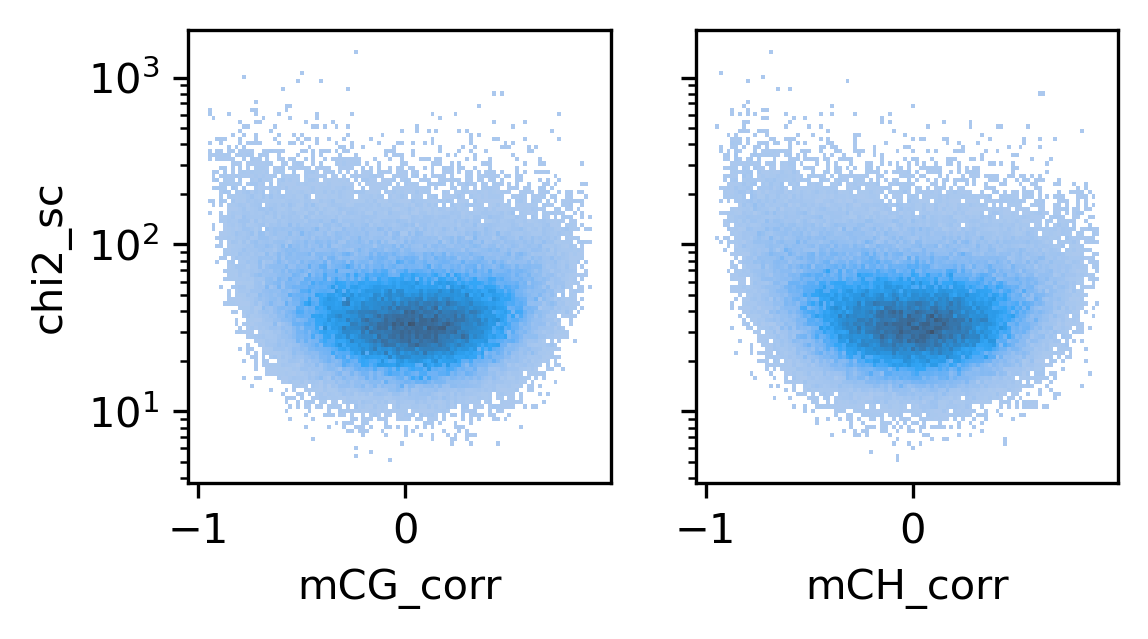

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(4,2), sharey='all', dpi=300)
ax = axes[0]
sns.histplot(binall, x='mCG_corr', y='chi2_sc', bins=100, ax=ax, log_scale=(False, 10))
ax = axes[1]
sns.histplot(binall, x='mCH_corr', y='chi2_sc', bins=100, ax=ax, log_scale=(False, 10))


<AxesSubplot:xlabel='insfc', ylabel='chi2_sc'>

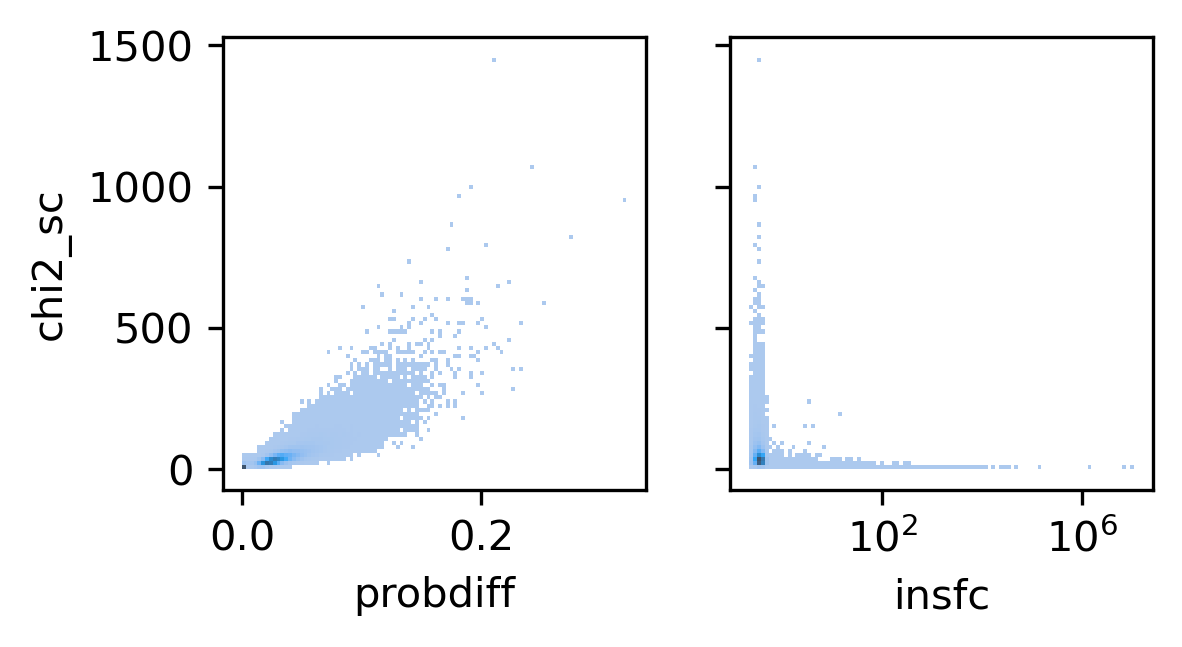

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(4,2), sharey='all', dpi=300)
ax = axes[0]
sns.histplot(binall, y='chi2_sc', x='probdiff', bins=100, ax=ax, log_scale=(False, False))
ax = axes[1]
sns.histplot(binall, y='chi2_sc', x='insfc', bins=100, ax=ax, log_scale=(10, False))
